In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diamonds/diamonds.csv


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [3]:
df = pd.read_csv('/kaggle/input/diamonds/diamonds.csv')

In [4]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
df.shape

(53940, 11)

### Data preprocessing

In [6]:
# Check if there are missing values
df.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [7]:
# drop the first unnamed column
df = df.drop(columns = 'Unnamed: 0')

In [8]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


##### From the description of the data it may be noticed that the minimum values of x, y, and z are zeros. This is not possible

In [9]:
# Check how many zeros in x,y, and z columns
zero_counts = (df == 0).sum()
zero_counts

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
price       0
x           8
y           7
z          20
dtype: int64

In [10]:
# Since there are not so many columns with zeros
# I will drop them
df = df.drop(df[df['x']==0].index)
df = df.drop(df[df['y']==0].index)
df = df.drop(df[df['z']==0].index)

In [11]:
zero_counts = (df == 0).sum()
zero_counts

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

#### Building pairplots of data

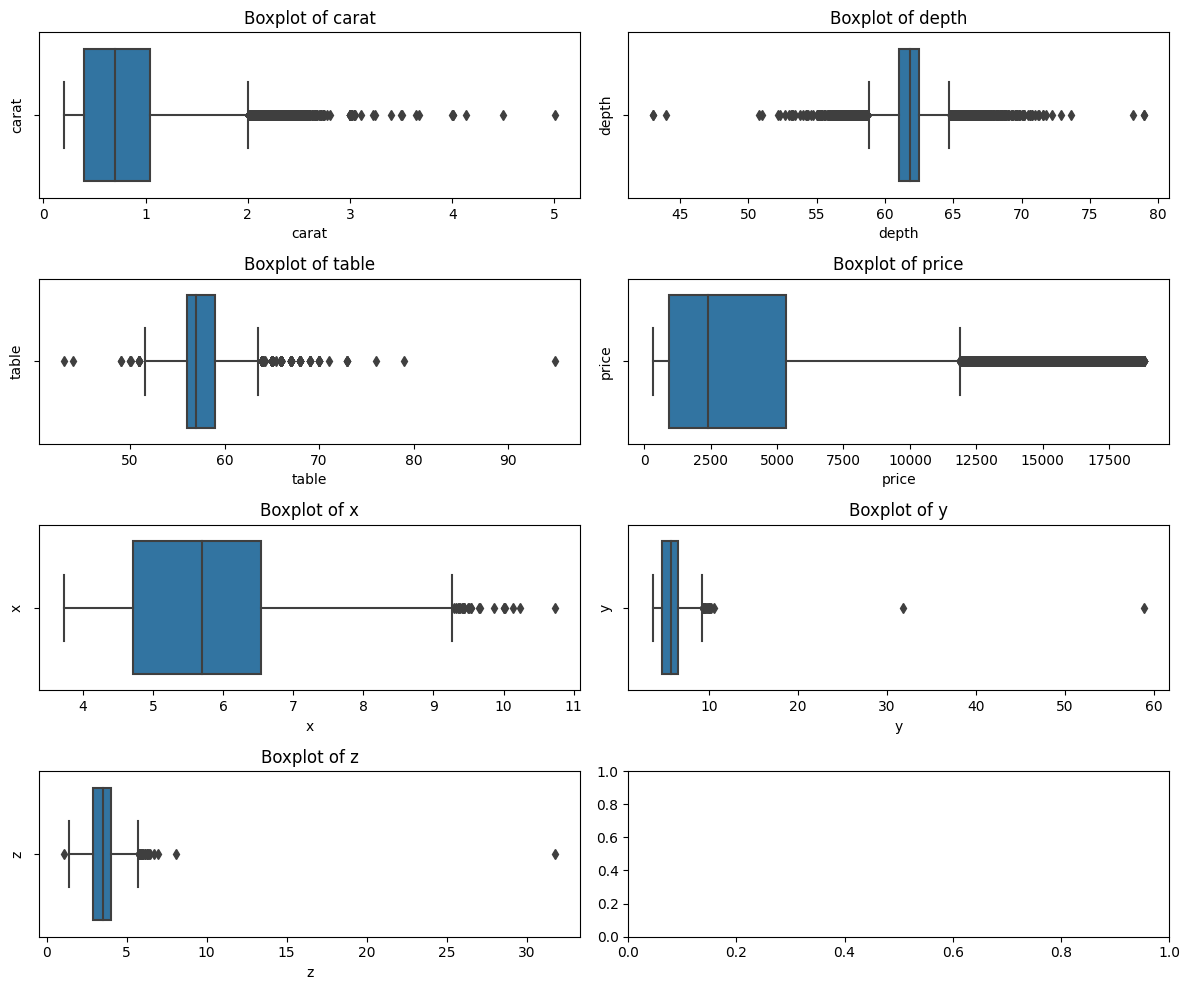

In [12]:
# check the distribution of numerical features
numerical = [col for col in df.columns if df[col].dtype != 'object']

fig, axes = plt.subplots(4, 2, figsize=(12, 10))

for i, feature in enumerate(numerical):
    row, col = divmod(i, 2)

    sns.boxplot(x=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f"Boxplot of {feature}")
    axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

#### There are outliers in some features.

##### Especially, z and y columns have extreme outliers that have to be eliminated

In [13]:
# Lets build regression plots to take a better look at the putliers
features = ['x', 'y', 'z', 'table', 'depth']

#Define function for building reg plots for some features vs target

def get_reg_plots(features):
        
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    for i, feature in enumerate(features):
        row, col = divmod(i, 2)
    
        sns.regplot(data=df, x = 'price', y=feature, fit_reg=True,
                    scatter_kws={'color': 'red'},
                    line_kws={'color': 'blue'},
                    ax=axes[row, col])
        axes[row, col].set_title(f'regression of price vs {feature}')
        axes[row, col].set_ylabel(feature)
    
    plt.tight_layout()
    plt.show()

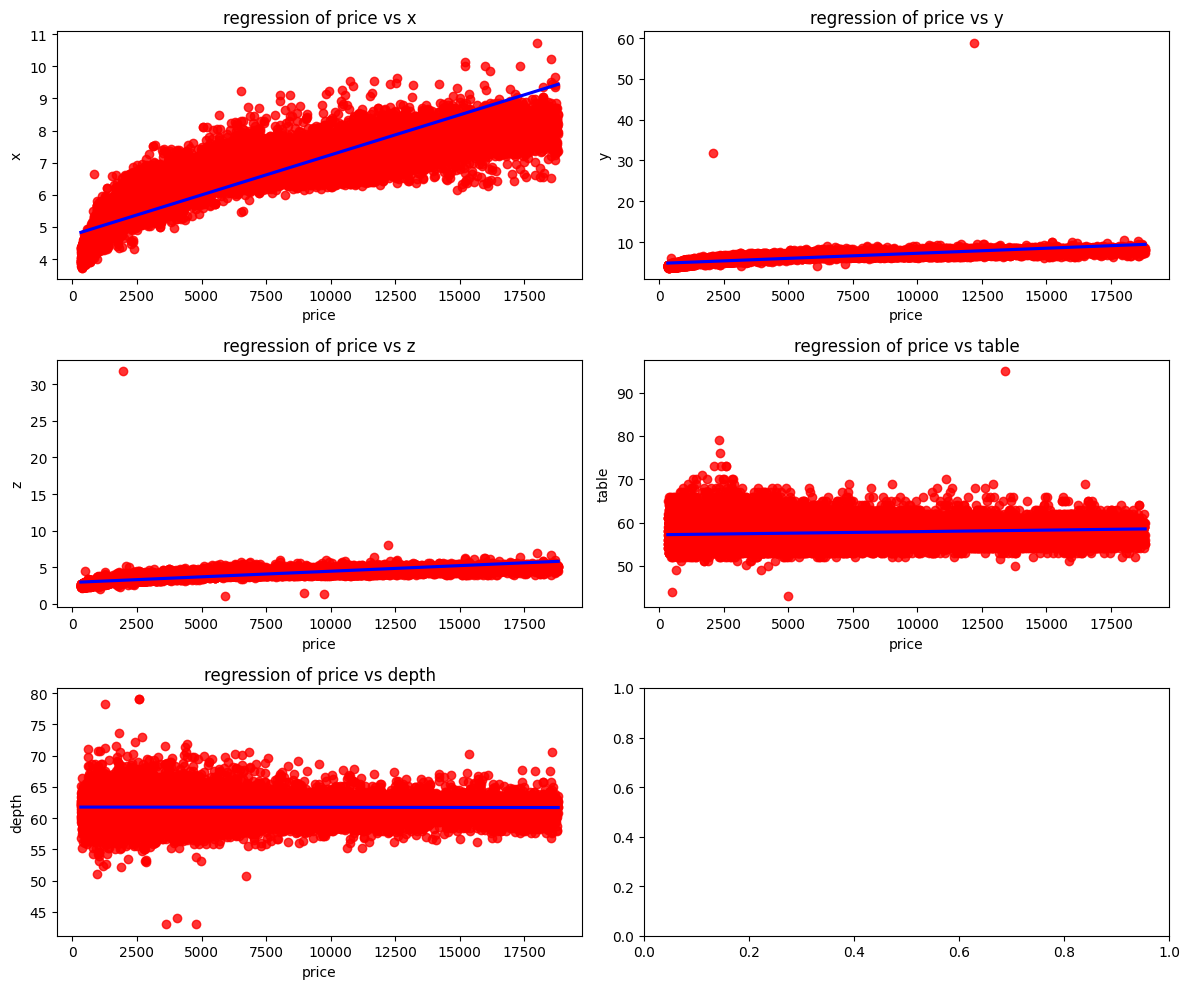

In [14]:
get_reg_plots(features)

##### The outliers are clearly visible in the plots above. Using these graphs, I will define boundaries for the columns and remove values that fall beyond them.

In [15]:
boundaries = {
    'depth': (45, 75),  
    'table': (40, 80),   
    'x': (0, 30),
    'y': (0, 30),
    'z': (2, 30),
}

# Drop rows with values outside the boundaries
for col, (lower, upper) in boundaries.items():
    df = df[(df[col] > lower) & (df[col] < upper)]

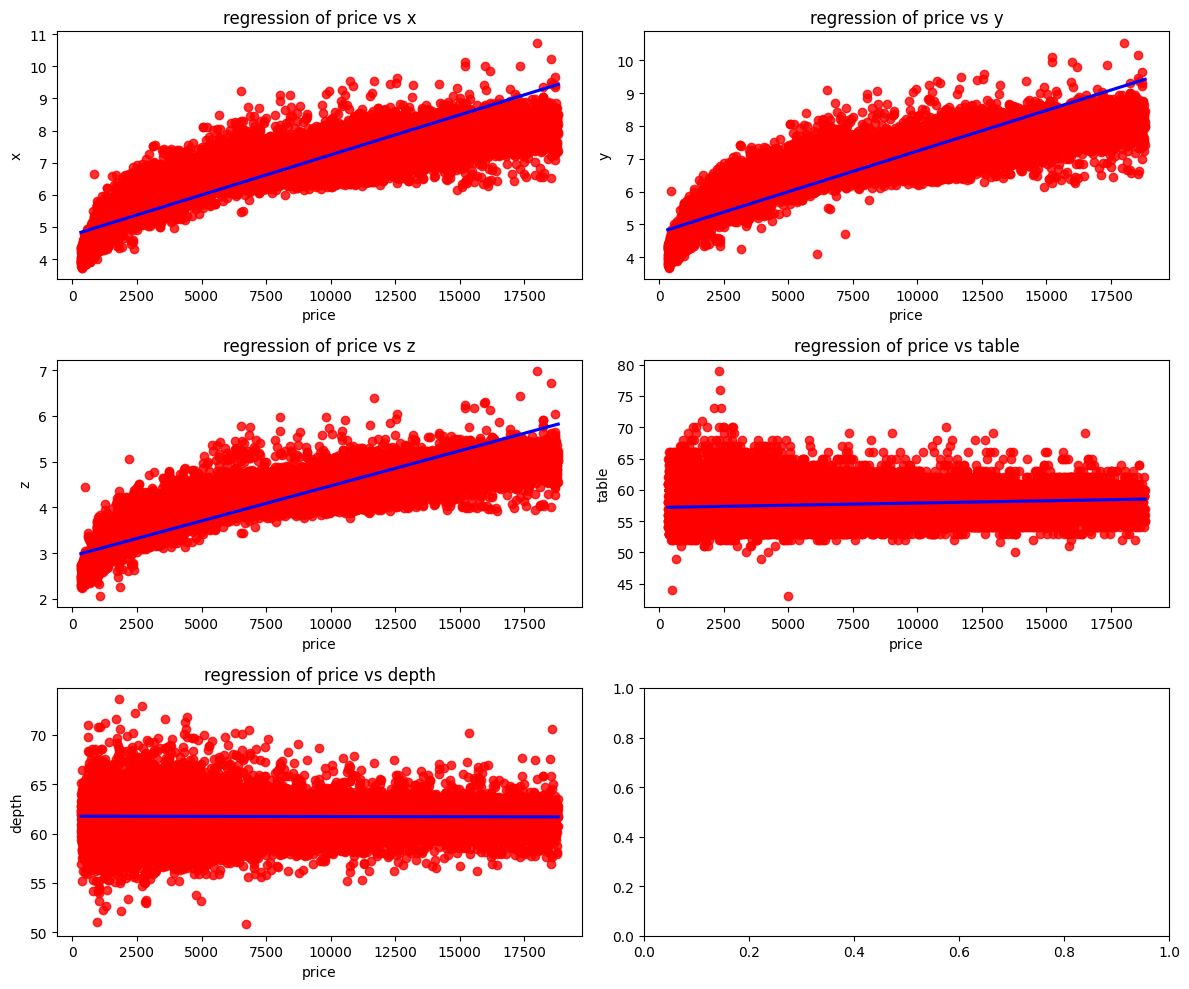

In [16]:
# check for outliers
get_reg_plots(features)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

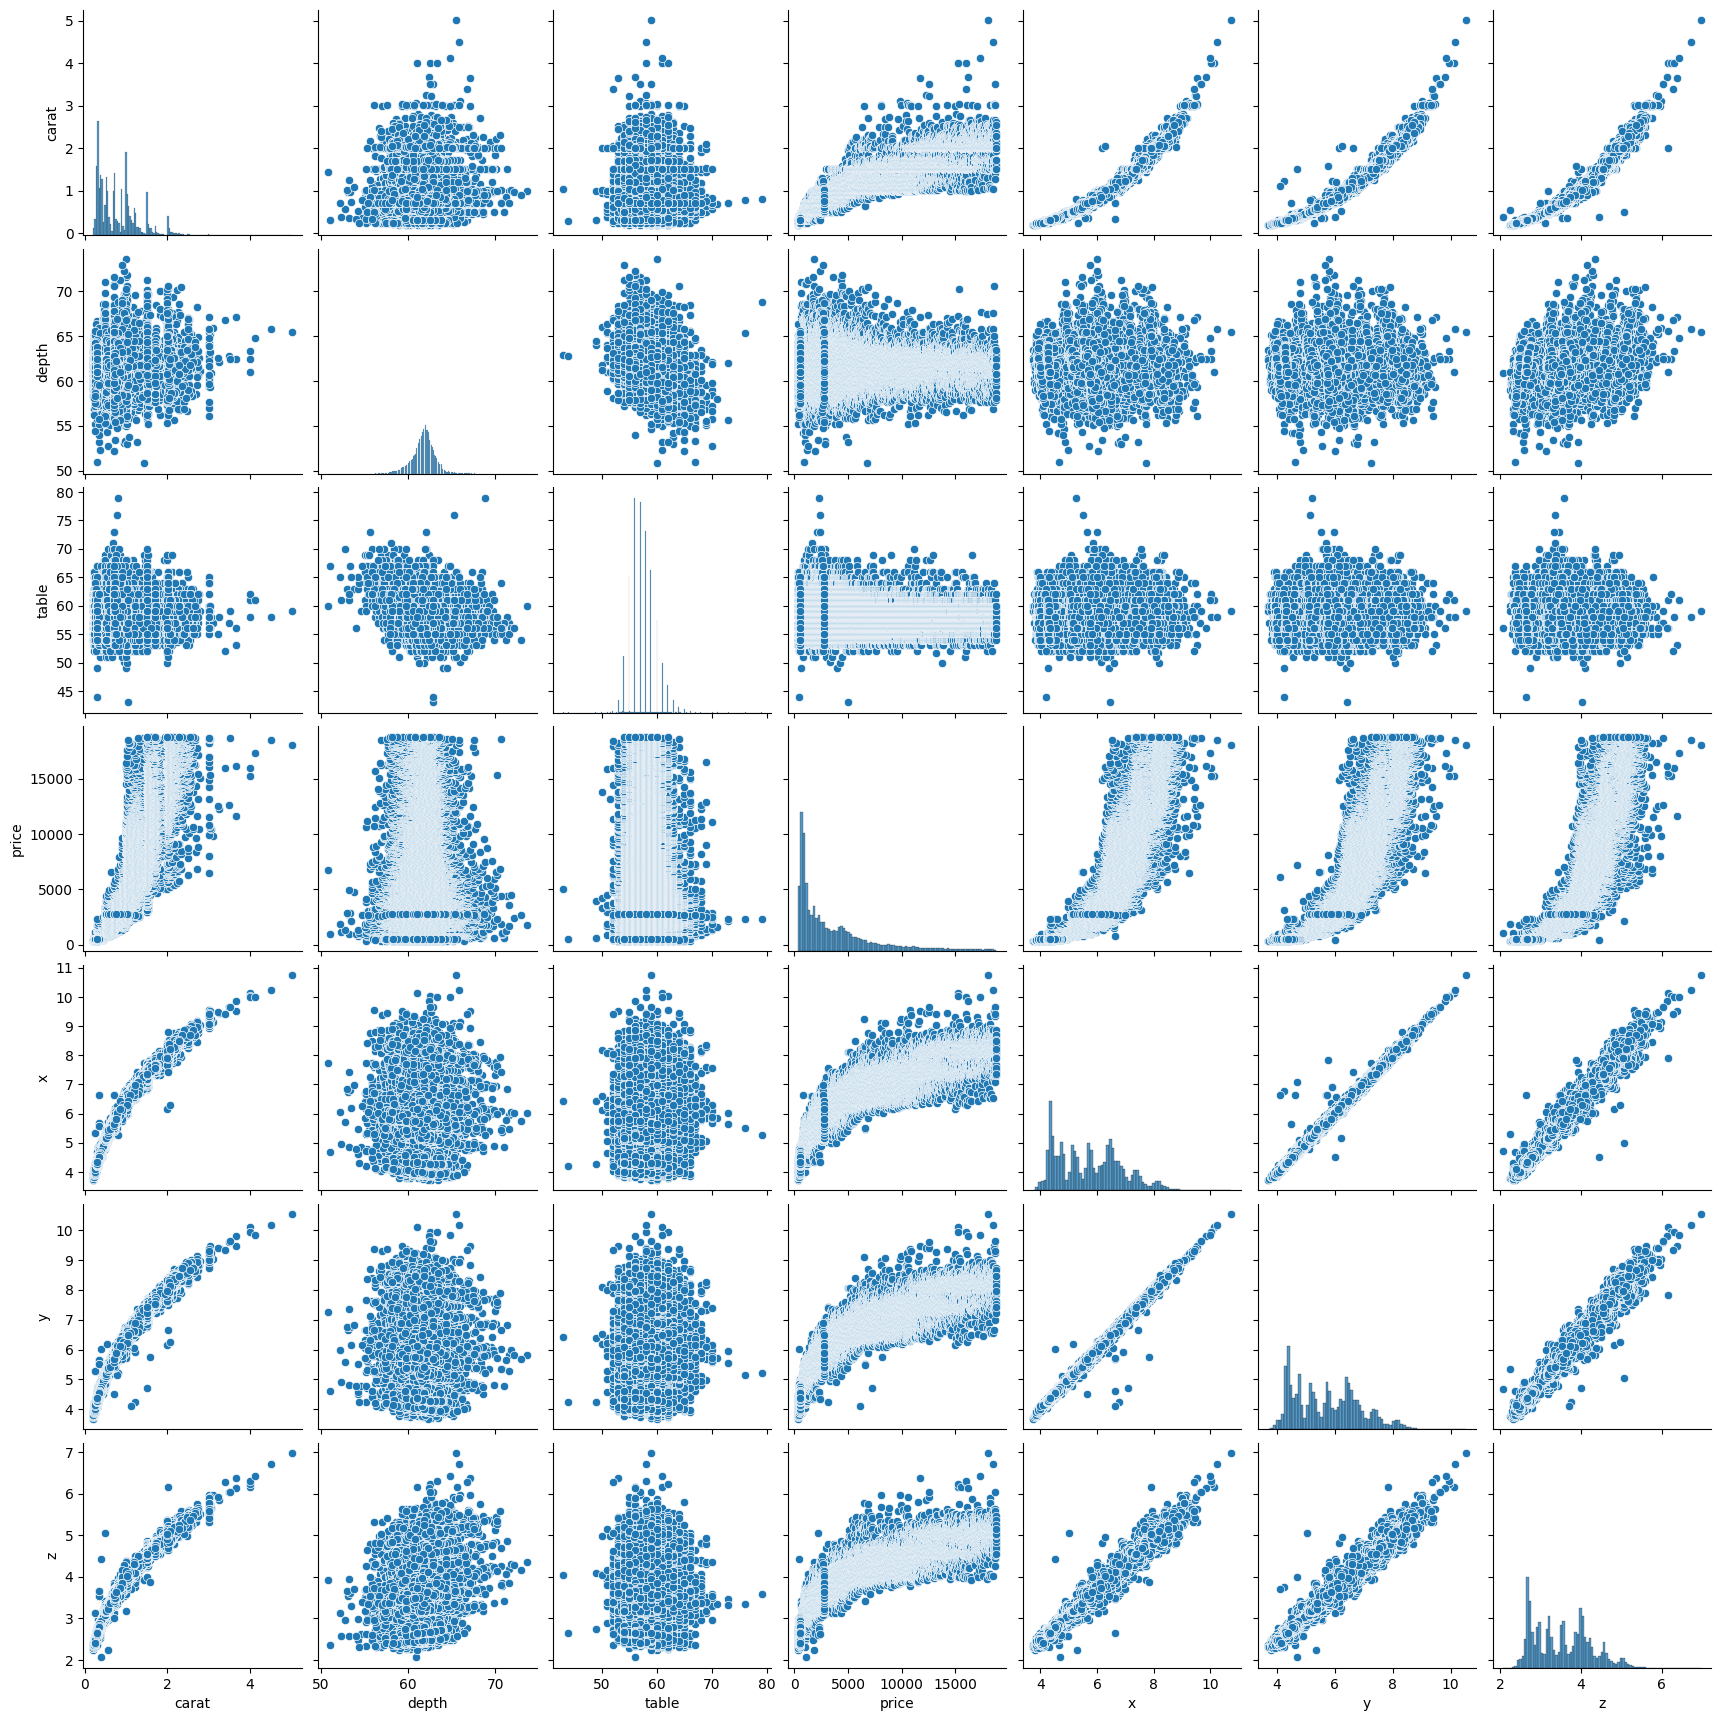

In [17]:
# Build a pairplot for checking relationships between columns
ax = sns.pairplot(data=df[numerical])

##### Lets take a look at categorical variables

In [18]:
categorical = [col for col in df.columns if df[col].dtype == 'object']

In [19]:
categorical

['cut', 'color', 'clarity']

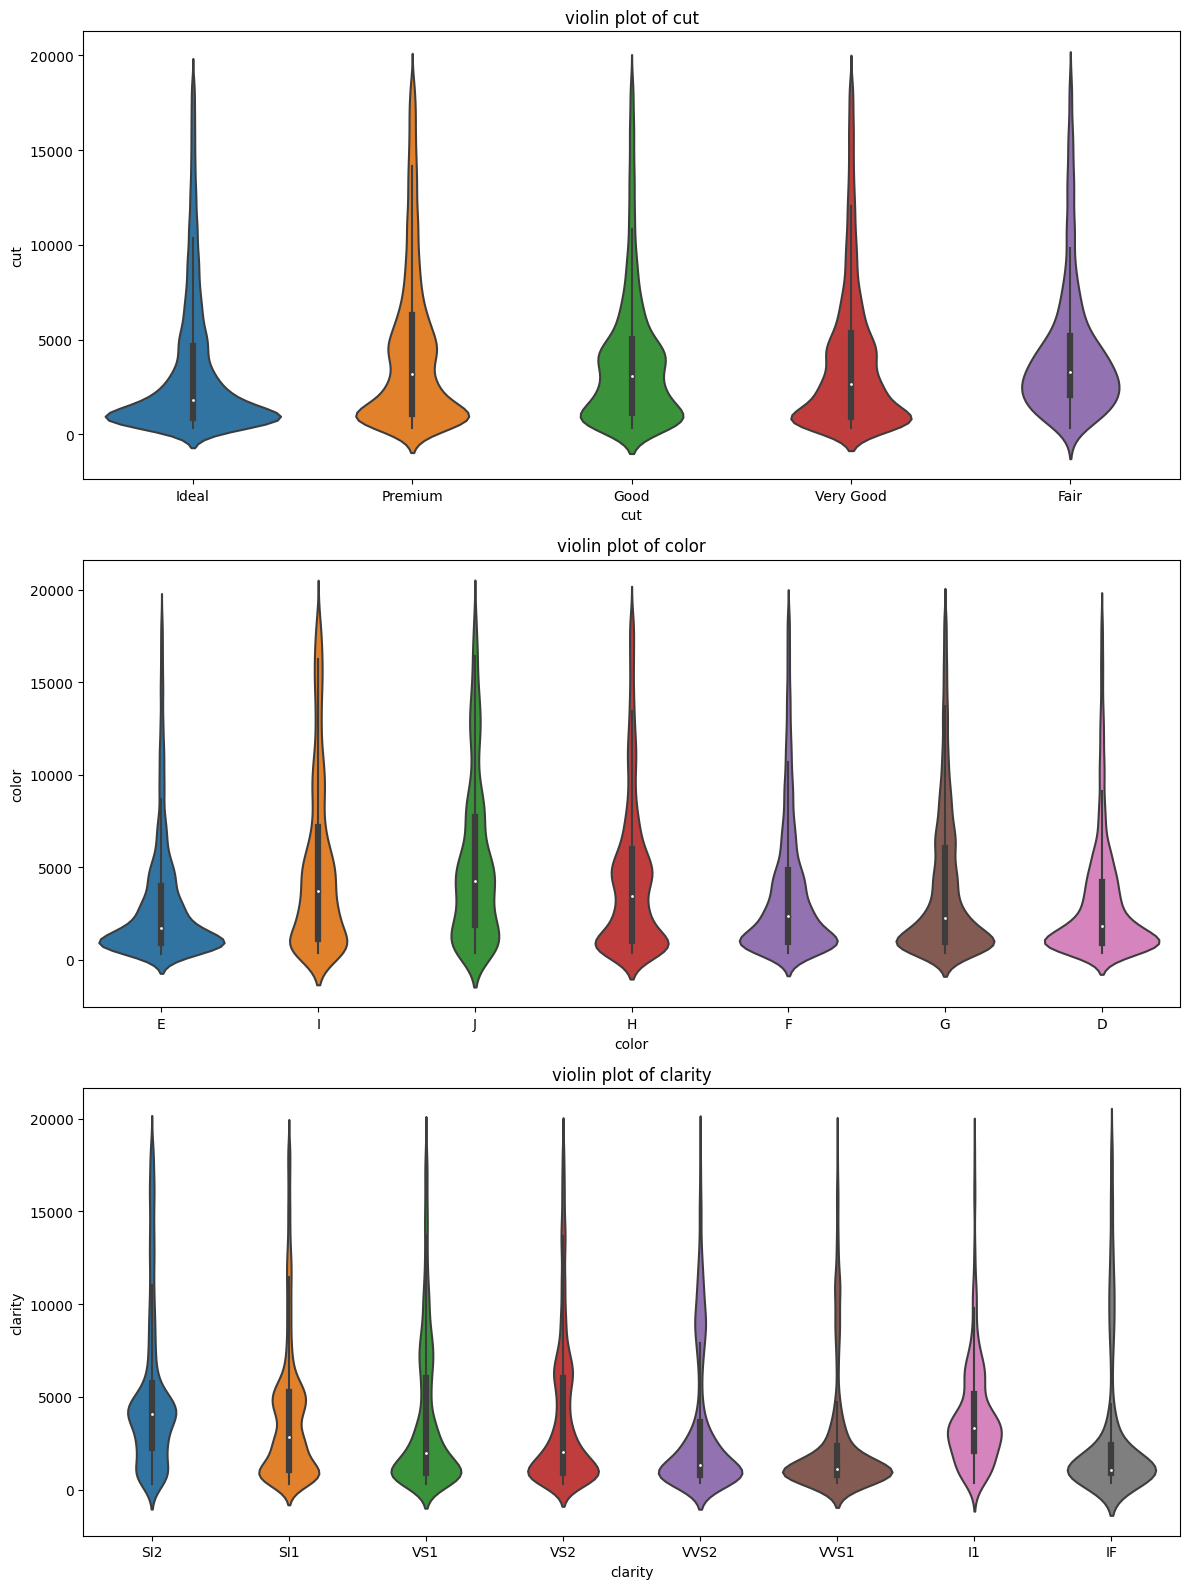

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
for i, feature in enumerate(categorical):  
    sns.violinplot(data=df, x = feature, y='price', ax=axes[i])
    axes[i].set_title(f'violin plot of {feature}')
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

#### Encoding categorical variables

In [22]:
# Using LabelEncoder
df_encoded = df.copy()

label_encoder = LabelEncoder()

for column in categorical:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

In [24]:
# The result of encoding
df_encoded.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


<Axes: >

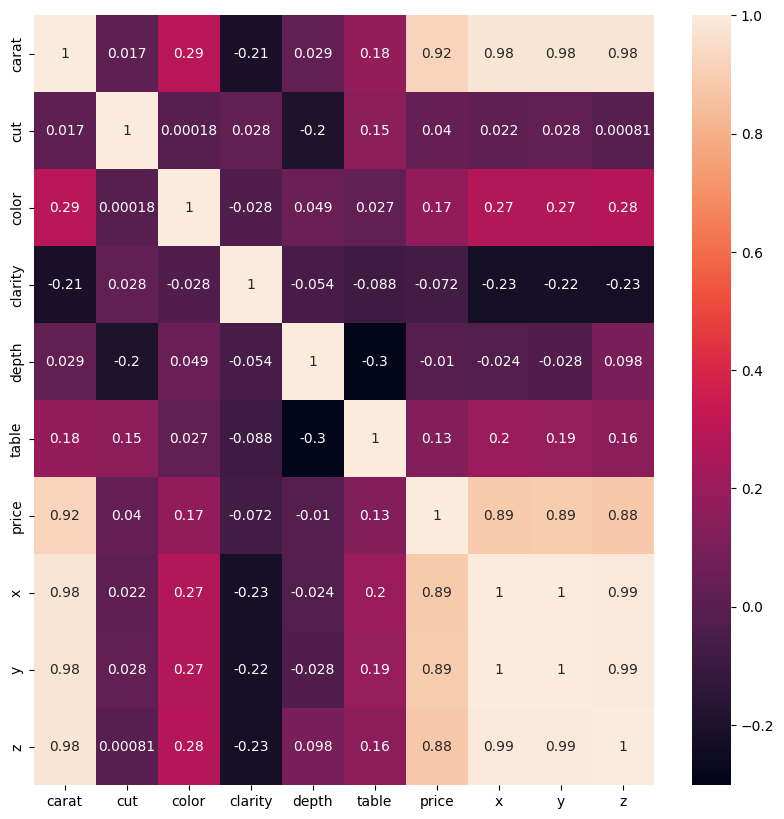

In [27]:
# Check the correlation between all columns
plt.figure(figsize=(10,10))

sns.heatmap(data=df_encoded.corr(), annot=True)

### Building a model

In [28]:
X = df_encoded.drop(columns='price')
y = df_encoded['price']

In [31]:
# Splitting data sets into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
# Building pipelines of scaling and model for different algorithms
# For linear regression
pipeline_lr = Pipeline([('scaler_1', StandardScaler()), 
                        ('linearRegression', LinearRegression())])

# For Decision tree regressor
pipeline_dt = Pipeline([('scaler_2', StandardScaler()),
                        ('DecisionTreeRegressor', DecisionTreeRegressor())])

# For Random forest regressor
pipeline_rf = Pipeline([('scaler_3', StandardScaler()),
                        ('RandomForestRegressor', RandomForestRegressor())])

# For Kneighbors regressor
pipeline_kn = Pipeline([('scaler_4', StandardScaler()),
                        ('KNeighborsRegressor', KNeighborsRegressor())])

# For XGBRegressor
pipeline_xgb = Pipeline([('scaler_5', StandardScaler()),
                        ('XGBRegressor', XGBRegressor())])

In [34]:
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]
pipe_dict = {0: 'LinearRegression', 1: 'DecisionTreeRegressor', 
             2: 'RandomForestRegressor', 3: 'KNeighborsRegressor',
             4: 'XGBRegressor'}

In [35]:
# Fitting all the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [37]:
# Performing ccross-validation 
results = []

for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    results.append(cv_score)
    print(pipe_dict[i], cv_score.mean())

LinearRegression -856.7410801241307
DecisionTreeRegressor -370.6309300024734
RandomForestRegressor -276.7455685391957
KNeighborsRegressor -423.042958199357
XGBRegressor -284.0815903727088


### XGBRegressor and RandomForestRegressor gave the best results

In [58]:
# Perform hyperparameter tuning for these models
param_grid_rf = {
    'RandomForestRegressor__n_estimators': [100, 200, 300],
    'RandomForestRegressor__max_depth': [None, 10, 20],
}

In [59]:
# Set up GridSearchCV for random forest model
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf, param_grid=param_grid_rf, 
    scoring='neg_mean_absolute_error', cv=5, n_jobs=-1
)

In [60]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler_3', StandardScaler()),
                                       ('RandomForestRegressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'RandomForestRegressor__max_depth': [None, 10, 20],
                         'RandomForestRegressor__n_estimators': [100, 200,
                                                                 300]},
             scoring='neg_mean_absolute_error')

In [61]:
grid_search_rf.best_score_

-275.8756904123015

In [75]:
param_grid_xgb = {
    'XGBRegressor__n_estimators': [100, 200, 300],
    'XGBRegressor__learning_rate': [0.01, 0.05, 0.1],
    'XGBRegressor__max_depth': [3, 5, 7],
    'XGBRegressor__min_child_weight': [1, 5, 10],
    'XGBRegressor__subsample': [0.6, 0.8],
    'XGBRegressor__colsample_bytree': [0.6, 0.8]
}

In [76]:
# Set up GridSearchCV for xgb model
grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb, param_grid=param_grid_xgb, 
    scoring='neg_mean_absolute_error', cv=5, n_jobs=-1
)

In [77]:
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler_5', StandardScaler()),
                                       ('XGBRegressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importan...
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'XGBRegressor__colsample_bytree': [0.6, 0.8],
                         'XGBRegressor__learning_rate': [0.01, 0.05, 0.1],
                         'XGBRegressor__max_depth': [3, 5, 7],
                         'XGBRegressor__min_child_weight': [1, 5, 10],
                         'XGBRegressor__n_estimators': [100, 200, 300],
                         'XGBRegressor__subsample': [0.6, 0.8]},
             scoring='neg_mean_absolute_error')

In [78]:
grid_search_xgb.best_score_

-274.00705005571206

#### Tuned XGBRegressior model showed better result than RandomForest model

#### Making prediction

In [79]:
best_model = grid_search_xgb.best_estimator_

In [84]:
# fitting the best pipeline
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler_5', StandardScaler()),
                ('XGBRegressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [85]:
prediction = best_model.predict(X_test)

In [87]:
# Model evaluation
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('R^2:', metrics.r2_score(y_test, prediction))

MSE: 281466.00325707835
RMSE: 530.5336966273475
MAE: 266.2775868897517
R^2: 0.9814454282329068
